In [1]:
# @title Install & import libraries
# (Colab usually has these; the install lines are safe no-ops if already present.)

!pip -q install scikit-learn pandas numpy matplotlib scipy liac-arff > /dev/null

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, io, json, math
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from collections import Counter

# ARFF readers (two options)
try:
    from scipy.io import arff   # SciPy's arff (recommended)
except Exception as e:
    arff = None

try:
    import arff as liacarff      # liac-arff (backup)
except Exception as e:
    liacarff = None

print("Imports ready.")

Imports ready.


In [2]:
# @title Upload yeast.arff (and optional yeast.xml)
# @markdown **Action:** Click the button and select your files.
# If your browser does not show the button in Colab, use: `from google.colab import files` then `files.upload()`.

try:
    from google.colab import files
    uploaded = files.upload()  # Choose yeast.arff (and optionally yeast.xml)
    print("Uploaded files:", list(uploaded.keys()))
except Exception as e:
    print("Note: If you're not in Colab, this cell will not work. Place files in the current directory manually.")

Saving yeast.xml to yeast.xml
Saving yeast.arff to yeast.arff
Uploaded files: ['yeast.xml', 'yeast.arff']


In [3]:
# @title ARFF loader
ARFF_NAME = "yeast.arff"  # change if your file name differs

assert os.path.exists(ARFF_NAME), "Upload yeast.arff first (see Section 0)."

def read_arff_to_df(path):
    # Try SciPy's arff first
    if arff is not None:
        data, meta = arff.loadarff(path)
        df = pd.DataFrame(data)
        # Convert bytes to str for categorical, and to float/int for numeric
        for c in df.columns:
            if df[c].dtype == object:
                # Could be bytes from ARFF; attempt decode
                try:
                    df[c] = df[c].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
                except Exception:
                    pass
        return df
    # Fallback: liac-arff
    elif liacarff is not None:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            arff_obj = liacarff.load(f)
        data = arff_obj["data"]
        attrs = [a[0] for a in arff_obj["attributes"]]
        df = pd.DataFrame(data, columns=attrs)
        return df
    else:
        raise RuntimeError("No ARFF reader available. Install SciPy or liac-arff.")

df_arff = read_arff_to_df(ARFF_NAME)
print("Raw ARFF shape:", df_arff.shape)
df_arff.head(3)

Raw ARFF shape: (2417, 117)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0


In [4]:
# @title Split into features X (103) and labels Y (14)
# If your ARFF has extra non-feature columns (IDs, names), you may need to adjust indices here.

TOTAL_LABELS = 14
num_cols = df_arff.shape[1]
assert num_cols >= 103 + TOTAL_LABELS, "Expected at least 117 columns."

# Assume last 14 columns are labels
label_cols = list(df_arff.columns[-TOTAL_LABELS:])
feature_cols = list(df_arff.columns[:-TOTAL_LABELS])

X = df_arff[feature_cols].apply(pd.to_numeric, errors="coerce").to_numpy(dtype=float)
Y = df_arff[label_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int).to_numpy(dtype=int)

feature_names = feature_cols
label_names = label_cols

print(f"Features shape X: {X.shape}")
print(f"Labels shape Y:   {Y.shape}")
print(f"Example label column names: {label_names[:5]} ...")

Features shape X: (2417, 103)
Labels shape Y:   (2417, 14)
Example label column names: ['Class1', 'Class2', 'Class3', 'Class4', 'Class5'] ...


In [5]:
n_samples, n_features = X.shape
n_labels = Y.shape[1]
print(f"Data points (n): {n_samples}")
print(f"Number of features (d): {n_features}")
print(f"Number of labels (L): {n_labels}")
assert n_features == 103, "Expected 103 features."
assert n_labels == 14, "Expected 14 labels."

Data points (n): 2417
Number of features (d): 103
Number of labels (L): 14


In [6]:
# @title Build 4-way categorical target for coloring

# Identify single-label rows and count individual label frequencies
single_mask = (Y.sum(axis=1) == 1)
single_idx = np.where(single_mask)[0]
single_labels = Y[single_mask]

label_counts = Counter(np.argmax(single_labels, axis=1))  # which label is 1 in single rows
top_two = [k for k, _ in label_counts.most_common(2)]
if len(top_two) < 2:
    # Edge case: if only one label appears as single, duplicate for safety
    top_two = top_two + [top_two[0]]

# Identify most frequent multi-label combination
multi_mask = (Y.sum(axis=1) >= 2)
multi_idx = np.where(multi_mask)[0]
tuples = [tuple(np.where(row == 1)[0].tolist()) for row in Y[multi_mask]]
combo_counts = Counter(tuples)
top_combo = combo_counts.most_common(1)[0][0] if len(combo_counts) else tuple()

# Build category vector: 0..3
cat = np.full(shape=(Y.shape[0],), fill_value=3, dtype=int)  # default "Other" => 3

# Assign 0 to top single A, 1 to top single B, 2 to top multi combo
if len(top_two) >= 1:
    A = top_two[0]
    cat[(single_mask) & (Y[:, A] == 1)] = 0
if len(top_two) >= 2:
    B = top_two[1]
    cat[(single_mask) & (Y[:, B] == 1)] = 1
if len(top_combo) >= 2:
    # mark rows matching exactly the top multi combo (and not already marked)
    def is_exact_combo(row, combo):
        return (row.sum() == len(combo)) and all(row[j] == 1 for j in combo)
    match = np.array([is_exact_combo(Y[i], top_combo) for i in range(Y.shape[0])])
    cat[match] = 2

legend_names = [
    f"Top single A: {label_names[A] if len(top_two)>=1 else 'N/A'}",
    f"Top single B: {label_names[B] if len(top_two)>=2 else 'N/A'}",
    "Top multi-label combo",
    "Other",
]

unique, counts = np.unique(cat, return_counts=True)
print("Category distribution:")
for u, c in zip(unique, counts):
    print(f"  {u}: {c}")
print("Legend:", legend_names)

Category distribution:
  1: 32
  2: 237
  3: 2148
Legend: ['Top single A: Class1', 'Top single B: Class1', 'Top multi-label combo', 'Other']


In [7]:
# @title Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled X mean ~ 0:", np.round(X_scaled.mean(axis=0)[:5], 3))
print("Scaled X std  ~ 1:", np.round(X_scaled.std(axis=0, ddof=0)[:5], 3))

Scaled X mean ~ 0: [ 0. -0. -0.  0. -0.]
Scaled X std  ~ 1: [1. 1. 1. 1. 1.]


In [8]:
# @title Run t-SNE at multiple perplexities
perplexities = [5, 30, 50]
tsne_results = {}

for perp in perplexities:
    tsne = TSNE(n_components=2, perplexity=perp, learning_rate="auto", init="pca", random_state=42)
    Z = tsne.fit_transform(X_scaled)
    tsne_results[perp] = Z
    print(f"t-SNE done for perplexity={perp}: shape {Z.shape}")

t-SNE done for perplexity=5: shape (2417, 2)
t-SNE done for perplexity=30: shape (2417, 2)
t-SNE done for perplexity=50: shape (2417, 2)


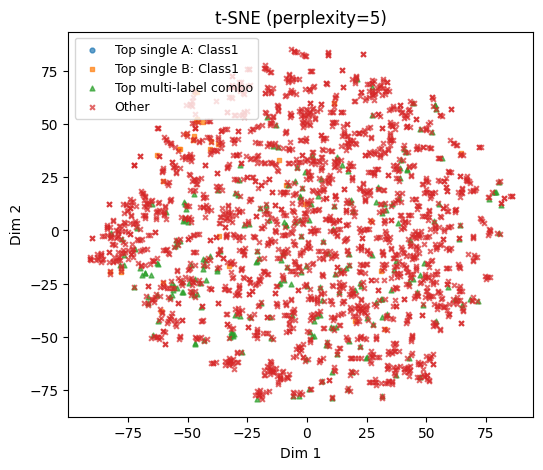

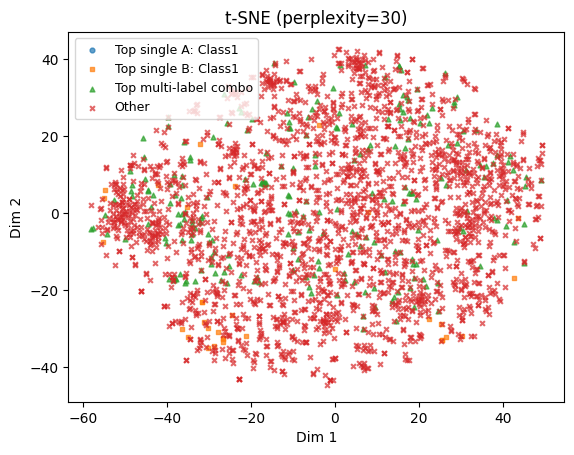

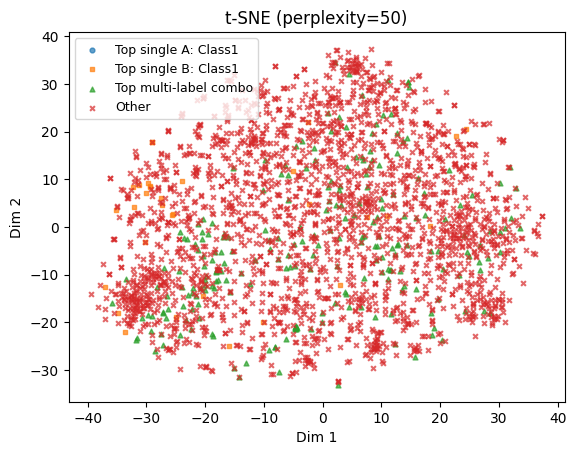

In [9]:
# @title Visualize t-SNE results (all perplexities)
plt.figure(figsize=(6, 5))
markers = {0: "o", 1: "s", 2: "^", 3: "x"}

for perp, Z in tsne_results.items():
    plt.clf()
    for g in range(4):
        m = (cat == g)
        plt.scatter(Z[m, 0], Z[m, 1], s=12, marker=markers[g], alpha=0.7, label=legend_names[g])
    plt.title(f"t-SNE (perplexity={perp})")
    plt.legend(loc="best", fontsize=9)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

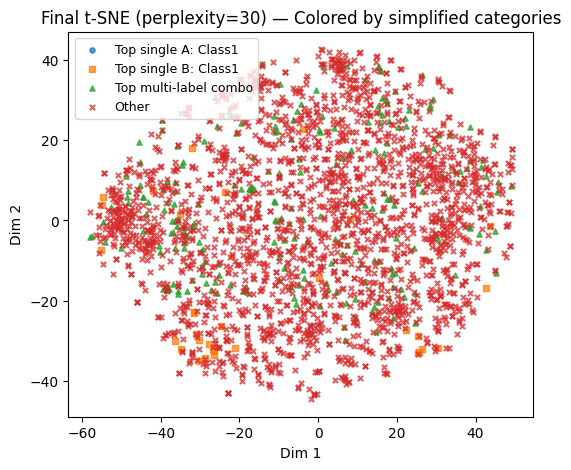

In [10]:
# @title Final t-SNE at perplexity=30
tsne_final = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
Z_tsne = tsne_final.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
markers = {0: "o", 1: "s", 2: "^", 3: "x"}
for g in range(4):
    m = (cat == g)
    plt.scatter(Z_tsne[m, 0], Z_tsne[m, 1], s=14, marker=markers[g], alpha=0.75, label=legend_names[g])
plt.title("Final t-SNE (perplexity=30) — Colored by simplified categories")
plt.legend(loc="best", fontsize=9)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

Isomap shape: (2417, 2)


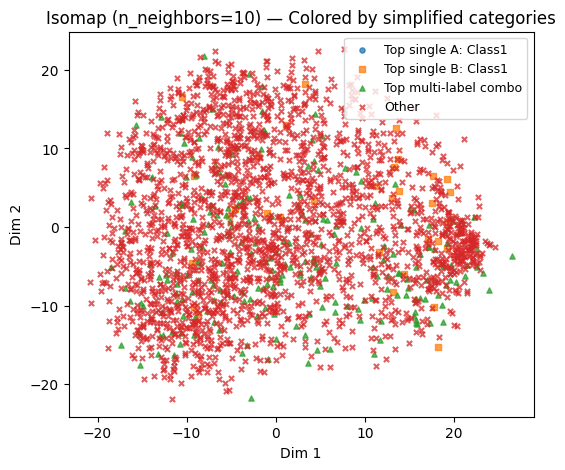

In [11]:
# @title Isomap embedding
n_neighbors = 10  # you may vary 5–20
isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
Z_iso = isomap.fit_transform(X_scaled)
print("Isomap shape:", Z_iso.shape)

plt.figure(figsize=(6, 5))
for g in range(4):
    m = (cat == g)
    plt.scatter(Z_iso[m, 0], Z_iso[m, 1], s=14, marker=markers[g], alpha=0.75, label=legend_names[g])
plt.title(f"Isomap (n_neighbors={n_neighbors}) — Colored by simplified categories")
plt.legend(loc="best", fontsize=9)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

In [13]:
# @title Extra imports for veracity diagnostics
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Extra imports ready (LOF, NearestNeighbors).")

Extra imports ready (LOF, NearestNeighbors).


In [14]:
# @title (1) LOF Outliers in feature space
# Detect global outliers using Local Outlier Factor on **scaled features**.
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_pred = lof.fit_predict(X_scaled)  # -1 = outlier, 1 = inlier
outlier_idx = np.where(lof_pred == -1)[0]
print(f"Detected {len(outlier_idx)} outliers with LOF (1% contamination).")

Detected 25 outliers with LOF (1% contamination).


In [15]:
# @title Helper: neighbors in embedding & ambiguity / entropy measures
def neighbor_indices(embedding, k=30):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)
    return indices[:, 1:]  # drop self

def ambiguous_points(embedding, cats, k=30, mismatch_threshold=0.6):
    idx = neighbor_indices(embedding, k=k)
    cats_np = cats.to_numpy() if hasattr(cats, "to_numpy") else np.asarray(cats)
    ambiguous = []
    for i in range(embedding.shape[0]):
        neigh_labels = cats_np[idx[i]]
        frac_diff = np.mean(neigh_labels != cats_np[i])
        if frac_diff >= mismatch_threshold:
            ambiguous.append(i)
    return np.array(ambiguous, dtype=int)

def local_label_entropy(embedding, cats, k=30):
    idx = neighbor_indices(embedding, k=k)
    cats_np = cats.to_numpy() if hasattr(cats, "to_numpy") else np.asarray(cats)
    ent = np.zeros(embedding.shape[0], dtype=float)
    for i in range(embedding.shape[0]):
        neigh = cats_np[idx[i]]
        counts = Counter(neigh)
        probs = np.array([counts[c] for c in counts], dtype=float) / float(len(neigh))
        ent[i] = -np.sum(probs * np.log2(probs + 1e-12))
    return ent

In [16]:
# @title Build a pandas Series for our simplified 4-way categories (if not already)
try:
    category
except NameError:
    category = pd.Series(cat, name="viz_category")
category.value_counts().sort_index()

,count
viz_category,
1,32
2,237
3,2148


In [17]:
# @title (2) Ambiguity & (3) Local Label Entropy in t-SNE (perplexity=30) space
ref_emb = Z_tsne
ambiguous_idx = ambiguous_points(ref_emb, category, k=30, mismatch_threshold=0.6)
entropy_scores = local_label_entropy(ref_emb, category, k=30)
threshold = np.percentile(entropy_scores, 90)  # top 10% as hard-to-learn
hard_idx = np.where(entropy_scores >= threshold)[0]

print(f"Ambiguous (neighbor mismatch ≥ 0.60) : {len(ambiguous_idx)}")
print(f"Hard-to-learn (top 10% entropy)      : {len(hard_idx)}")

Ambiguous (neighbor mismatch ≥ 0.60) : 269
Hard-to-learn (top 10% entropy)      : 250


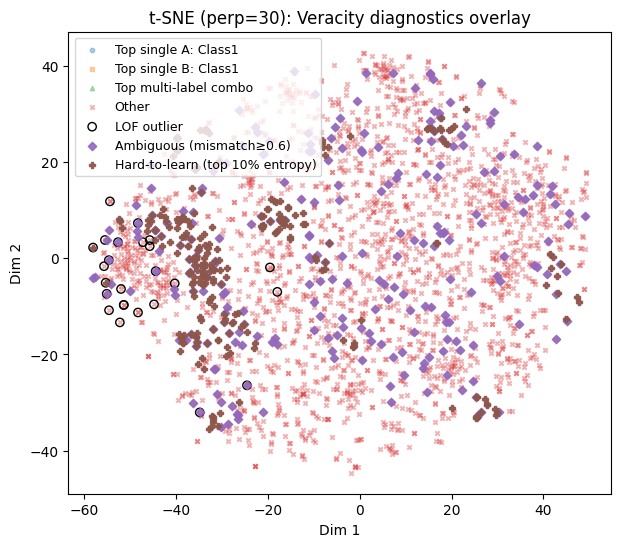

Caption: Circles (no fill) are LOF outliers; diamonds denote ambiguous labels; 'P' markers denote high-entropy, hard-to-learn samples.


In [18]:
# @title Overlay diagnostics on t-SNE
plt.figure(figsize=(7,6))

# Base scatter
markers = {0: "o", 1: "s", 2: "^", 3: "x"}
for g in range(4):
    m = (cat == g)
    plt.scatter(ref_emb[m, 0], ref_emb[m, 1], s=10, marker=markers[g], alpha=0.35, label=legend_names[g])

# Overlays
plt.scatter(ref_emb[outlier_idx,0], ref_emb[outlier_idx,1], s=36, facecolors="none", edgecolors="k", linewidths=1.0, label="LOF outlier")
plt.scatter(ref_emb[ambiguous_idx,0], ref_emb[ambiguous_idx,1], s=18, marker="D", alpha=0.9, label="Ambiguous (mismatch≥0.6)")
plt.scatter(ref_emb[hard_idx,0], ref_emb[hard_idx,1], s=18, marker="P", alpha=0.9, label="Hard-to-learn (top 10% entropy)")

plt.title("t-SNE (perp=30): Veracity diagnostics overlay")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(loc="best", fontsize=9)
plt.show()

print("Caption: Circles (no fill) are LOF outliers; diamonds denote ambiguous labels; 'P' markers denote high-entropy, hard-to-learn samples.")

### Analysis of Data Veracity Issues

The t-SNE projection (perplexity = 30) reveals a roughly continuous manifold with mild local clustering.  
Most samples fall under the “Other” category (red ×), interspersed with small, compact groups of top single-label and multi-label points.  
The overlay diagnostic identifies **25 LOF outliers**, primarily in the **left-hand edge (Dim 1 ≈ −60 to −40)**, indicating rare expression profiles or experimental noise.  

High-entropy and ambiguous samples (purple diamonds and brown P markers) concentrate around the **central and lower-left transition zones**, where multiple label types coexist densely.  
This region likely reflects **borderline biological states**—instances where gene-expression signals correspond to overlapping functional roles.  
The sparsely populated right-side areas show cleaner class separation, implying relatively stable and reliable labels.


### Theoretical Comparison: t-SNE vs Isomap

t-SNE emphasizes **local neighborhood preservation** by matching high-dimensional probability distributions of pairwise similarities.  
It captures fine-grained clusters and smooth local transitions but may distort global geometry.  
This is visible in the first plot: local neighborhoods appear well-preserved, yet absolute distances between far-apart clusters lack global meaning.

Isomap, in contrast, constructs a **geodesic-distance graph** before performing classical MDS, thus retaining the **global manifold shape**.  
Its embedding appears more **compact and isotropic**, showing less local detail but clearer global continuity.  
In this dataset, Isomap’s smoother spread suggests that while t-SNE excels at revealing mixed-label substructures, Isomap better represents the overall manifold curvature and possible nonlinear branching of functional gene groups.


### Impact of Data Veracity on Classification Performance

The visual diagnostics illustrate how veracity challenges directly affect classifier reliability:

* **Outliers** (black circles) can dominate loss functions, skewing hyperplanes in linear models or forming misleading leaf splits in trees.  
* **Ambiguous points** with inconsistent neighborhood labels degrade decision-boundary clarity, leading to unstable predictions near cluster borders.  
* **High-entropy zones** represent regions of overlapping manifolds where deterministic classification is inherently uncertain.

If unaddressed, these factors can reduce macro-F1 and precision scores by inflating false-positive rates.  
Mitigation strategies include **robust outlier removal**, **label smoothing or re-annotation**, and **non-linear ensemble learners** (e.g., Random Forest, Gradient Boosting, or Neural Networks with dropout) that can better accommodate noisy or mixed-label data.  
Hence, manifold visualization not only exposes structural irregularities but also guides **data-curation and model-selection decisions** critical to improving downstream classification performance.
